In [3]:
import math
import numpy as np
import plotly.figure_factory as ff
import rasterio
import string 
import pandas as pd

from rasterio.plot import show
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, multivariate_normal
from scipy.ndimage import gaussian_filter
from PIL import Image
from matplotlib import cm



Variables iniciales

In [4]:
cmap = "viridis"
pi=math.pi

Importación de las imagenes

In [5]:
with rasterio.open('./img/cropped/red.tif') as src:
    red=src.read(1)
with rasterio.open('./img/cropped/nir.tif') as src:
    nir = src.read(1)

with rasterio.open('./img/2. IMG_700101_000458_0092_NIR.TIF') as src:
    nir_field = src.read(1)

with rasterio.open('img/3. IMG_700101_000458_0092_RED.TIF') as src:
    red_field = src.read(1)


/opt/homebrew/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Normalización de las imagenes

In [6]:
red = red/65535.0
nir = nir/65535.0
red_field = red_field/65535.0
nir_field = nir_field/65535.0

ndvi =(nir.astype(float)-red.astype(float)/(nir+red))
ndvi_field =(nir_field.astype(float)-red_field.astype(float)/(nir_field+red_field))

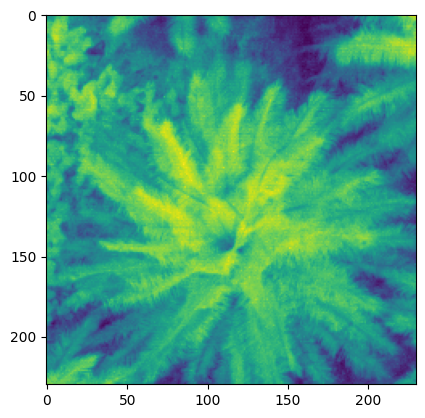

<Axes: >

In [7]:
show(ndvi, cmap=cmap)

In [8]:
print(ndvi.shape[1], ndvi.shape[0])

230 230


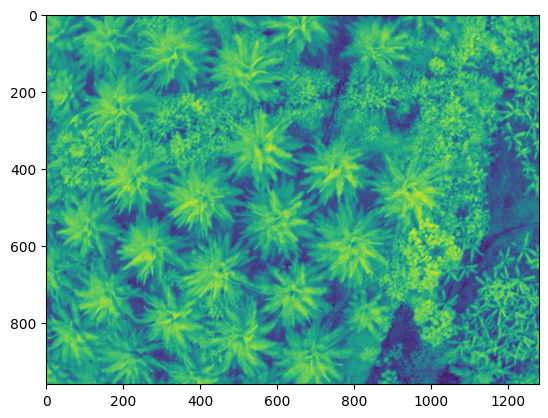

<Axes: >

In [9]:
show(ndvi_field, cmap = cmap)

Gráfica de una única curva

In [10]:
def calculate_ndvi(red, nir):
    ndvi = (nir - red) / (nir + red)
    return (ndvi)

In [11]:
def kurt_factor(ndvi):
    #return 1 + 1 * ndvi
    kurt_factor = np.mean((ndvi - np.mean(ndvi)) ** 4) / (np.var(ndvi) ** 2)
    return kurt_factor


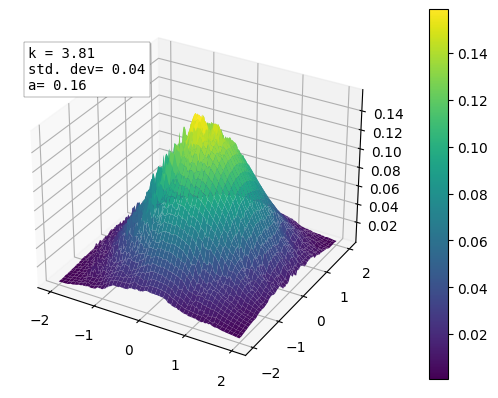

In [12]:
# Calculate the NDVI values
ndvi = (nir - red) / (nir + red)

def create_one_graph(ndvi):
    # Define the parameters for the Gaussian bell function
    x = 0 # center point
    y = 0  # center point
    sigma_xy = 1  # spread in the xy plane
    sigma_z = 1  # spread in the z direction
    Qm =1  # maximum value of the bell function

    # Create a meshgrid for the x, y, and NDVI values
    xf, yf = np.meshgrid(np.linspace(-2, 2, ndvi.shape[1]), np.linspace(-2, 2, ndvi.shape[0]))
    ndvif = np.meshgrid(np.linspace(-1, 1, ndvi.shape[1]), np.linspace(-1, 1, ndvi.shape[0]))[0]

    # Create the 3D Gaussian bell function based on the NDVI values
    
    #Proofs
    #f = (Qm * np.exp( -(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / ((2 * (np.pi ** (3/2)))* sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) ))
    #f = (Qm * np.exp( -(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / (2 * np.pi * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) ))
    #f = (Qm * np.exp( (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)))/ (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2)) 
    #f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2)) * np.exp( (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))
    #f = (Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2)) + np.exp(- (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)))
    #f = (Qm * np.exp(-(ndvif - ndvi) ** 2 / (2 * (sigma_z * kurt_factor(ndvi)) ** 2)) / ((2 * (np.pi ** (3/2))) * (sigma_xy ** 2) * (sigma_z * kurt_factor(ndvi)))) * (np.exp(-(xf - x) ** 2 / (2 * (sigma_xy * kurt_factor(ndvi)) ** 2) - (yf - y) ** 2 / (2 * (sigma_xy * kurt_factor(ndvi)) ** 2)))
    #f = (Qm * np.exp(-(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / ((2 * (np.pi ** (3/2))) * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2))) * kurt_factor(ndvi)

    #Real function (Funcion generica - funcional hasta el momento)
    f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))
    
    # Calculate the kurtosis, standard deviation, and amplitude of the plot
    kurtosis=kurt_factor(ndvi)
    std = np.std(f)
    amplitude = np.max(f)

    # Plot the 3D Gaussian bell function
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array(f)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    ax.plot_surface(xf, yf, f, cmap=cmap)
    textstr = '\n'.join((
        'k = {:.2f}'.format(kurtosis),
        'std. dev= {:.2f}'.format(std),
        'a= {:.2f}'.format(amplitude)))
    ax.text2D(0.05, 0.90, s=textstr, family='monospace', transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=0.2, boxstyle='square'))
    plt.rcParams['font.family'] = 'Times'

    
    plt.show()
    
create_one_graph(ndvi)

**VARIACIONES EN NDVI**

NDVI primera palma

In [13]:
ndvi_flat = ndvi.ravel()
ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
ndvi_flat = ndvi_flat[np.isfinite(ndvi_flat)]
mean = np.mean(ndvi_flat)
std = np.std(ndvi_flat)

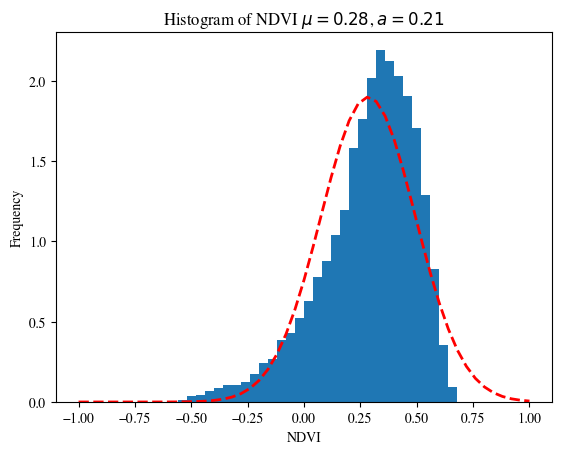

In [14]:
fig, ax = plt.subplots()
n, bins, patches = ax.hist(ndvi_flat, bins=50, density=True, range=(-1, 1))
y = norm.pdf(bins, mean, std)
l = ax.plot(bins, y, 'r--', linewidth= 2)
ax.set_xlabel('NDVI')
ax.set_ylabel('Frequency')
ax.set_title(r'Histogram of NDVI $\mu={:.2f}$, $a={:.2f}$'.format(mean, std))
plt.show()

Gráfica de múltiples campanas

In [15]:
# Create a meshgrid for the x, y, and NDVI values
xf, yf = np.meshgrid(np.linspace(-10, 10, ndvi_field.shape[1]), np.linspace(-10, 10, ndvi_field.shape[0]))
ndvif = np.meshgrid(np.linspace(-1, 1, ndvi_field.shape[1]), np.linspace(-1, 1, ndvi_field.shape[0]))[0]

def calculate_ndvi(red, nir):
    #Calculate the NDVI values
    ndvi = (nir - red) / (nir + red)
    return(ndvi)

def gaussian_with_image(Qm, x, y, sigma_xy, sigma_z, ndvi, ndvif, xf, yf):
    # Create the 3D Gaussian bell function based on the NDVI values
    #f = Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z) * np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) - (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2))
   
   #Proofs
    f = (Qm * np.exp( -(ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)) / ((2 * np.pi ** (3/2))* sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2) - (yf - y) ** 2 / (2 * sigma_xy ** 2) ))
    #f = (Qm / (2 * np.pi * sigma_xy ** 2 * sigma_z)) * (np.exp(-(xf - x) ** 2 / (2 * sigma_xy ** 2)- (yf - y) ** 2 / (2 * sigma_xy ** 2)) + np.exp(- (ndvif - ndvi) ** 2 / (2 * sigma_z ** 2)))
   
    #threshold = 1e-2
    #f[f < threshold] = np.nan
    return f

def plot_gaussian(f, xf, yf):
    # Plot the 3D Gaussian bell function
    ax.plot_surface(xf, yf, f, cmap='binary')


### Image Cropping

In [16]:
def image_cropper(ndvi_field,x1,y1,x2,y2):
    """
    This function is used to crop the image
    """
    ndvi_mask = np.zeros(ndvi_field.shape, dtype=np.uint8)
    ndvi_mask[y1:y2, x1:x2] = 1

    # Apply the mask to the NDVI image
    ndvi_field = np.array(ndvi_field) * ndvi_mask

    # Create a RGB image from the NDVI image
    return ndvi_field
    # Convert the Numpy array to a PIL Image object
    #img = Image.fromarray(rgb_field)

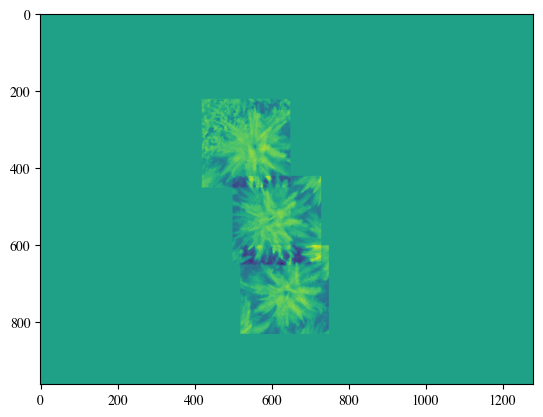

<Axes: >

In [17]:
ndvi1 = image_cropper(ndvi_field, 420, 220, 650, 450)
ndvi2 = image_cropper(ndvi_field, 500, 420, 730, 650)
ndvi3 = image_cropper(ndvi_field, 520, 600, 750, 830)
show(ndvi3+ndvi1+ndvi2)

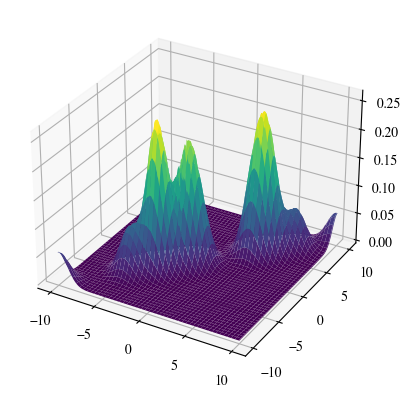

In [18]:
cmap2 = 'viridis'

f = gaussian_with_image(1, 0, 0, 1,1, ndvi1, ndvif, xf, yf)
f2 = gaussian_with_image(2, 4, 4, 1,1,ndvi2,ndvif,xf,yf)
f3 = gaussian_with_image(3, -3, -3, 1,1,ndvi3,ndvif,xf,yf)
f4 = gaussian_with_image(2, 5, 5, 1,1,ndvi1,ndvif,xf,yf)
f5 = gaussian_with_image(1, 7, 7, 1,1,ndvi1,ndvif,xf,yf)
f6= gaussian_with_image(1,10,10, 1,1,ndvi1,ndvif,xf,yf)
f7 = gaussian_with_image(2, -1, -1, 1,1,ndvi1,ndvif,xf,yf)
f8 = gaussian_with_image(1, -10, -10, 1,1,ndvi1,ndvif,xf,yf)
f9= gaussian_with_image(1,-5,-5, 1,1,ndvi1,ndvif,xf,yf)

ff = f+f2+f3+f4+f5+f6+f7+f8+f9

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xf, yf, ff, cmap=cmap2, alpha=1)

plt.show()

ANALISIS DE VARIACIONES SEGUN EL NDVI - UNIDADES DE CULTIVO DIFERENTES 

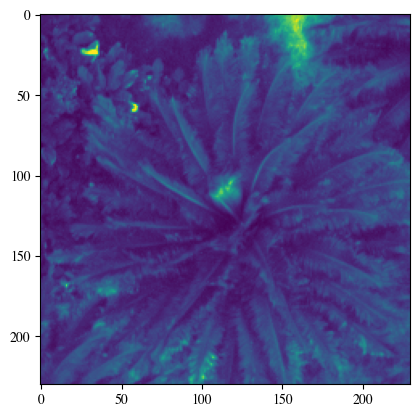

<Axes: >

In [19]:
show(red)

In [20]:
def image_cropper_sin_ceros(left, top, right, bottom):
    x1 = left
    y1 = top
    x2 = right
    y2 = bottom
    red_cropped = red_field[y1:y2, x1:x2]
    nir_cropped =nir_field[y1:y2, x1:x2]
    ndvi = calculate_ndvi(red_cropped, nir_cropped)
    return ndvi

In [21]:
ndvi1 = image_cropper_sin_ceros(420, 220, 650, 450)
ndvi2=image_cropper_sin_ceros(500, 420, 730, 650)
ndvi3=image_cropper_sin_ceros(520, 600, 750, 830)

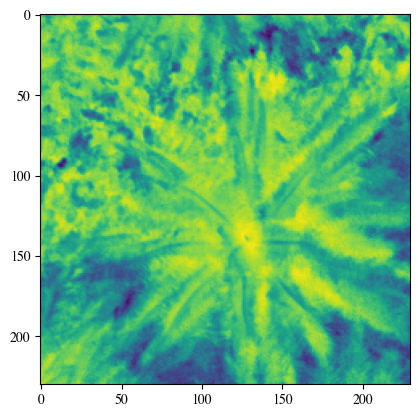

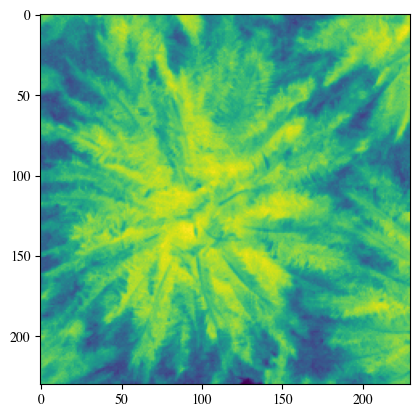

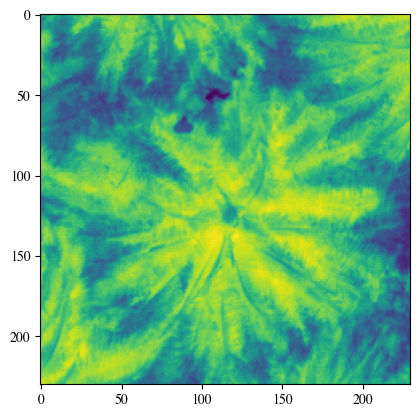

<Axes: >

In [22]:
show(ndvi1)
show(ndvi2)
show(ndvi3)

UNIDAD 1 - NDVI 1

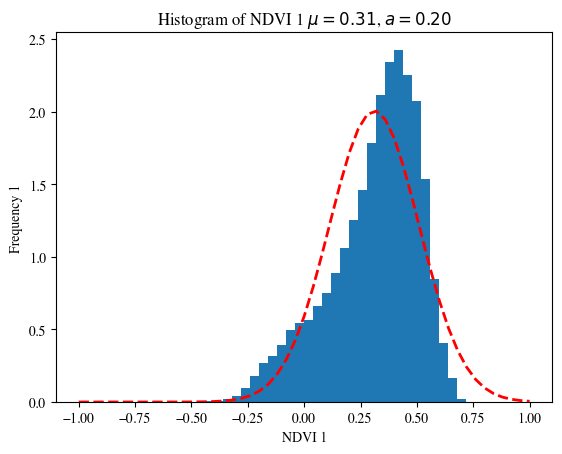

In [23]:
ndvi_flat1 = ndvi1.ravel()
ndvi_flat1 = ndvi_flat1[~np.isnan(ndvi_flat1)]
ndvi_flat1 = ndvi_flat1[np.isfinite(ndvi_flat1)]
mean = np.mean(ndvi_flat1)
std = np.std(ndvi_flat1)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(ndvi_flat1, bins=50, density=True, range=(-1, 1))
y = norm.pdf(bins, mean, std)
l = ax.plot(bins, y, 'r--', linewidth= 2)
ax.set_xlabel('NDVI 1')
ax.set_ylabel('Frequency 1')
ax.set_title(r'Histogram of NDVI 1 $\mu={:.2f}$, $a={:.2f}$'.format(mean, std))
plt.show()

UNIDAD 2 - NDVI 2

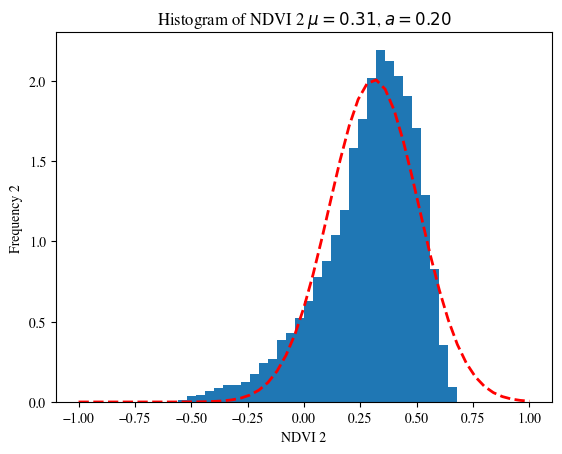

In [24]:
ndvi_flat2 = ndvi2.ravel()
ndvi_flat2 = ndvi_flat1[~np.isnan(ndvi_flat2)]
ndvi_flat2 = ndvi_flat2[np.isfinite(ndvi_flat2)]
mean = np.mean(ndvi_flat2)
std = np.std(ndvi_flat2)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(ndvi_flat, bins=50, density=True, range=(-1, 1))
y = norm.pdf(bins, mean, std)
l = ax.plot(bins, y, 'r--', linewidth= 2)
ax.set_xlabel('NDVI 2')
ax.set_ylabel('Frequency 2')
ax.set_title(r'Histogram of NDVI 2 $\mu={:.2f}$, $a={:.2f}$'.format(mean, std))
plt.show()

UNIDAD 3 - NDVI 3

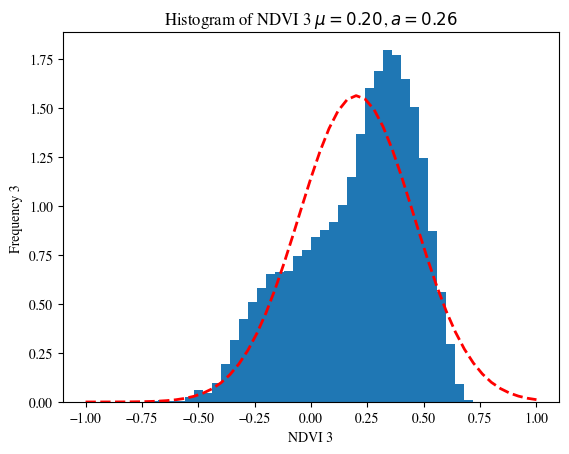

In [25]:
ndvi_flat3 = ndvi3.ravel()
ndvi_flat3 = ndvi_flat3[~np.isnan(ndvi_flat3)]
ndvi_flat3 = ndvi_flat3[np.isfinite(ndvi_flat3)]
mean = np.mean(ndvi_flat3)
std = np.std(ndvi_flat3)

fig, ax = plt.subplots()
n, bins, patches = ax.hist(ndvi_flat3, bins=50, density=True, range=(-1, 1))
y = norm.pdf(bins, mean, std)
l = ax.plot(bins, y, 'r--', linewidth= 2)
ax.set_xlabel('NDVI 3')
ax.set_ylabel('Frequency 3')
ax.set_title(r'Histogram of NDVI 3 $\mu={:.2f}$, $a={:.2f}$'.format(mean, std))
plt.show()

Histogram of NDVI: The histogram shows the distribution of the NDVI values. The x-axis of the histogram shows the NDVI values, and the y-axis shows the number of times each NDVI value occurs. The histogram is a good way to see the shape of the distribution of the NDVI values.
Probability density function of NDVI: The probability density function shows the probability of a given NDVI value occurring. The x-axis of the probability density function shows the NDVI values, and the y-axis shows the probability of each NDVI value occurring. The probability density function is a good way to see the spread of the NDVI values.

In [26]:
def flatGraph(ndvi3):
    ndvi_flat3 = ndvi3.ravel()
    ndvi_flat3 = ndvi_flat3[~np.isnan(ndvi_flat3)]
    ndvi_flat3 = ndvi_flat3[np.isfinite(ndvi_flat3)]
    mean = np.mean(ndvi_flat3)
    std = np.std(ndvi_flat3)

    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(ndvi_flat, bins=50, density=True, range=(-1, 1))
    y = norm.pdf(bins, mean, std)
    l = ax.plot(bins, y, 'r--', linewidth= 2)
    ax.set_xlabel('NDVI ')
    ax.set_ylabel('Frequency ')
    plt.legend(["NDVI Normal distribution", "Histogram of NDVI"], loc ="upper left")
    ax.set_title(r'Histogram of NDVI')
    textstr = '\n'.join((
        '$\mu={:.2f}$'.format(mean),
        '$\sigma={:.2f}$'.format(std)))
    ax.text(0.025, 0.80, s=textstr, transform=ax.transAxes, ha='left', va='top', bbox=dict(facecolor='white', alpha=1, edgecolor='black', linewidth=0.2, boxstyle='square'))
    plt.show()

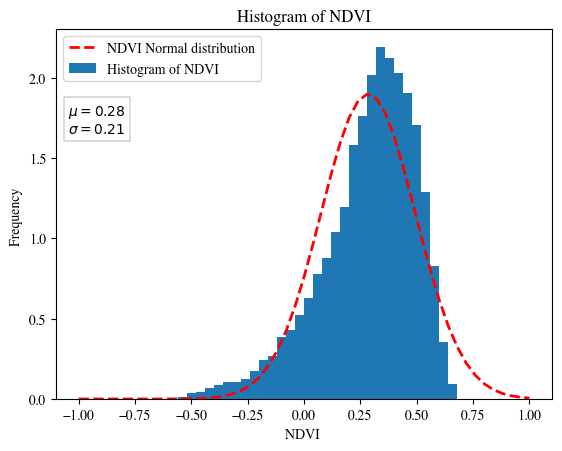

In [27]:
flatGraph(ndvi)

# ROC

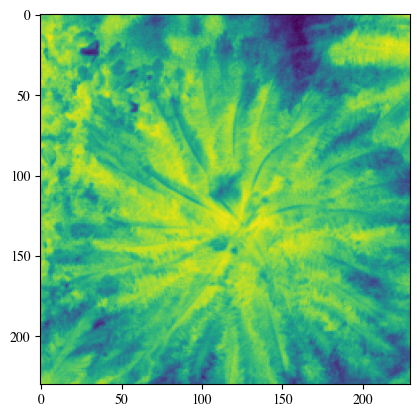

<Axes: >

In [28]:
show(ndvi)

In [29]:
def make_center_circle(image, radius):
  """
  This function takes an image and makes the pixels in the center be 0.

  Args:
    image: An image.
    radius: The radius of the circle.

  Returns:
    A new image with the pixels in the center set to 0.
  """

  # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the image.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels in the circle to 0.
  for i in range(center_x - radius, center_x + radius + 1):
    for j in range(center_y - radius, center_y + radius + 1):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance <= radius:
        image_array[i][j] = -1

  # Convert the NumPy array back to an image.
  new_image = Image.fromarray(image_array)

  return image_array



In [30]:
def make_circle_inside(image, radius):
  """
  This function takes a 230 by 230 matrix and makes the pixels outside the circle be 0.

  Args:
    matrix: A 230 by 230 matrix.
    radius: The radius of the circle.

  Returns:
    A new matrix with the pixels outside the circle set to 0.
  """

   # Convert the image to a NumPy array.
  image_array = np.array(image)

  # Get the height and width of the image.
  height = image_array.shape[0]
  width = image_array.shape[1]

  # Find the center of the matrix.
  center_x = width // 2
  center_y = height // 2

  # Set the pixels outside the circle to 0.
  for i in range(height):
    for j in range(width):
      distance = ((i - center_x) ** 2 + (j - center_y) ** 2) ** 0.5
      if distance > radius:
        image_array[i][j] = -1

  return image_array


PRUEBAS VARIACION KURTOSIS

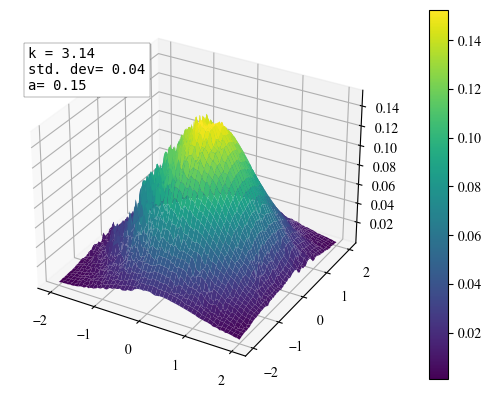

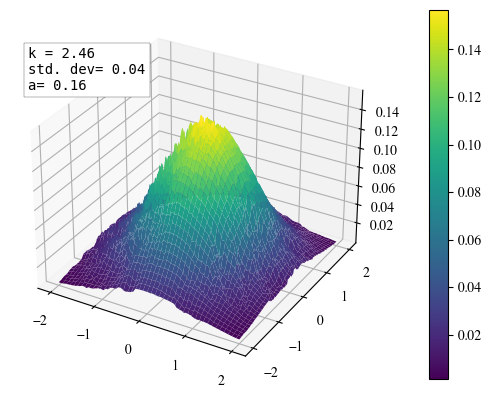

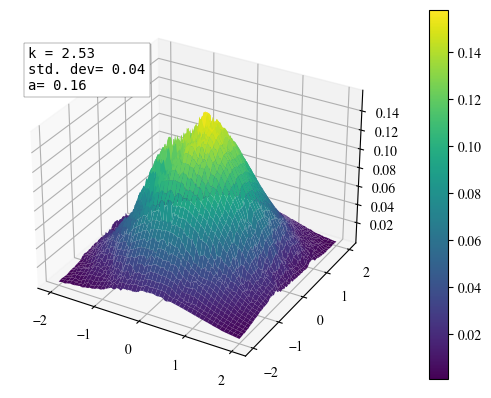

In [31]:
create_one_graph(ndvi1)
create_one_graph(ndvi2)
create_one_graph(ndvi3)


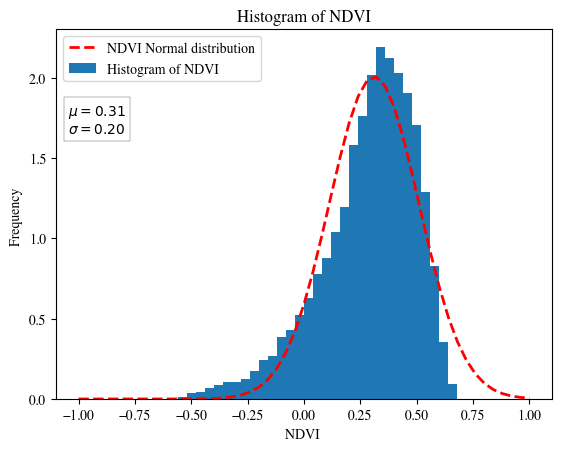

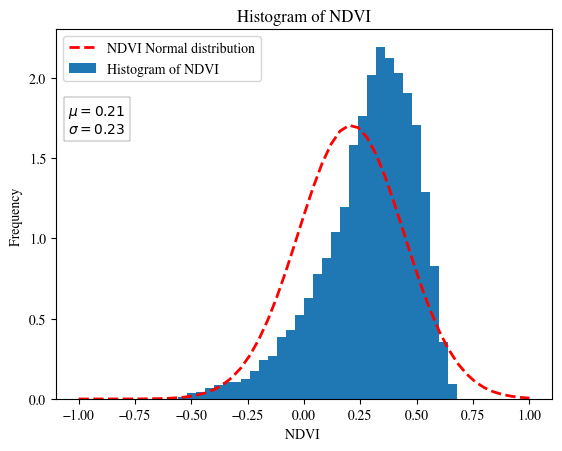

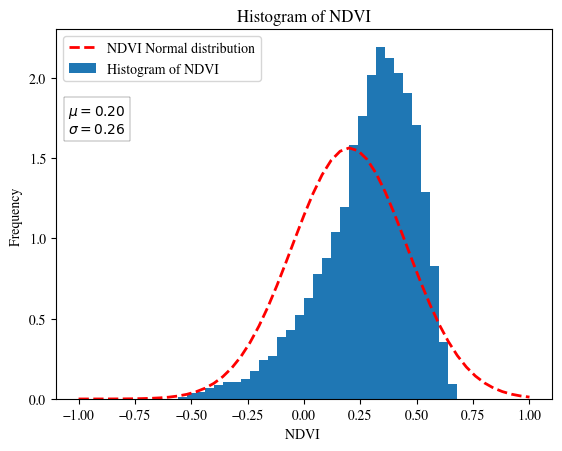

In [32]:
flatGraph(ndvi1)
flatGraph(ndvi2)
flatGraph(ndvi3)

In [33]:
def multiple_2d_plot(ndvi_list):

    fig, ax = plt.subplots()

    for i in range(0, len(ndvi_list)):
        ndvi_flat = ndvi_list[i].ravel()
        ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
        ndvi_flat = ndvi_flat[np.isfinite(ndvi_flat)]
        mean = np.mean(ndvi_flat)
        std = np.std(ndvi_flat)

        y = norm.pdf(bins, mean, std)
        l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Specimen {string.ascii_uppercase[i]}", color=plt.cm.rainbow(i/len(ndvi_list)))

    ax.set_xlabel('NDVI')
    ax.set_ylabel('Frequency')
    plt.legend(loc="upper left")
    ax.set_title(r'Normal distribution of NDVI values by Image')

    plt.show()


/var/folders/mg/_6sdzpzn5lx13z92xsyjwm280000gn/T/ipykernel_83020/2628017708.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Specimen {string.ascii_uppercase[i]}", color=plt.cm.rainbow(i/len(ndvi_list)))


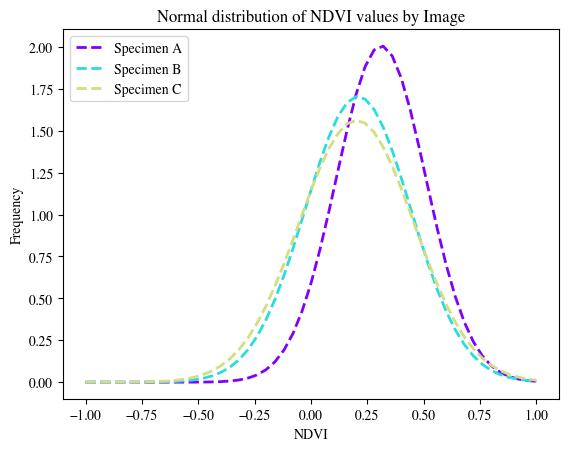

In [34]:
multiple_2d_plot([ndvi1, ndvi2, ndvi3])

# PRUEBAS DETECCIÓN DE ANOMALÍAS

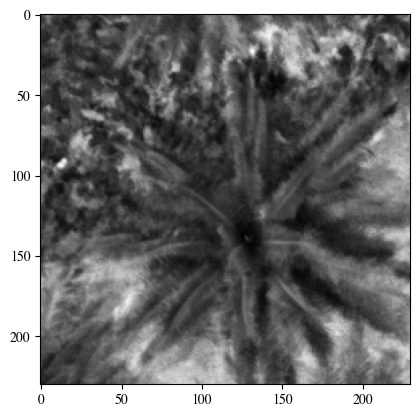

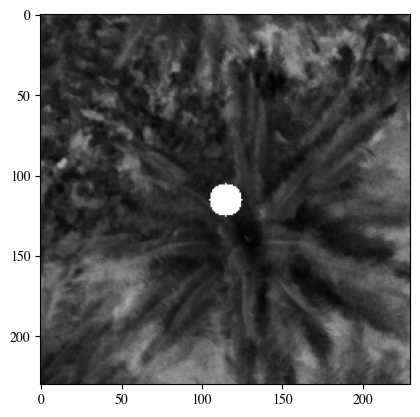

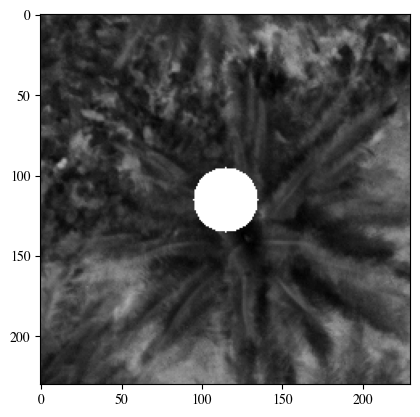

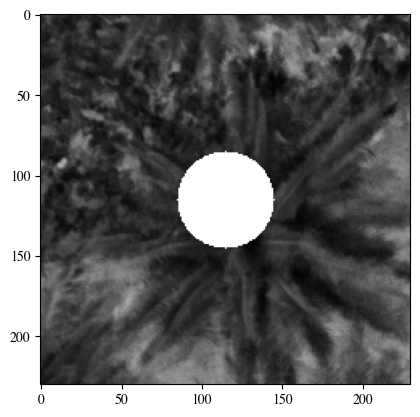

<Axes: >

In [35]:
ndvi_norm= ndvi1
show(ndvi_norm, cmap='binary')
sintetico1 = make_center_circle(ndvi_norm, 10)
sintetico2 = make_center_circle(ndvi_norm, 20)
sintetico3 = make_center_circle(ndvi_norm, 30)



show(sintetico1, cmap='binary')
show(sintetico2, cmap='binary')
show(sintetico3, cmap='binary')

In [36]:
def multiple_2d_plot(ndvi_list):

    fig, ax = plt.subplots()

    for i in range(0, len(ndvi_list)):
        ndvi_flat = ndvi_list[i].ravel()
        ndvi_flat = ndvi_flat[~np.isnan(ndvi_flat)]
        ndvi_flat = ndvi_flat[np.isfinite(ndvi_flat)]
        mean = np.mean(ndvi_flat)
        std = np.std(ndvi_flat)

        y = norm.pdf(bins, mean, std)
        if (i==0):
            l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Without Anomaly", color=plt.cm.rainbow(i/len(ndvi_list)))
        else:
            l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Anomaly radius {(i)*5} px", color=plt.cm.rainbow(i/len(ndvi_list)))

    ax.set_xlabel('NDVI')
    ax.set_ylabel('Frequency')
    plt.legend(loc="upper left")
    ax.set_title(r'Normal distribution of NDVI values by Image')

    plt.show()

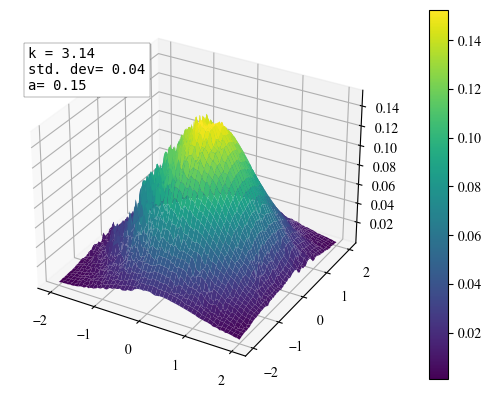

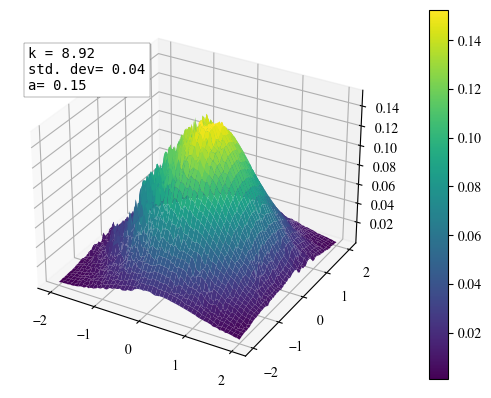

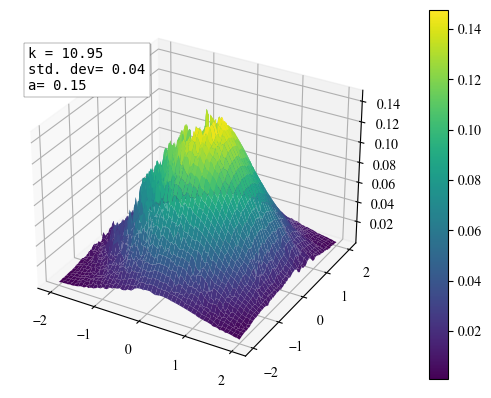

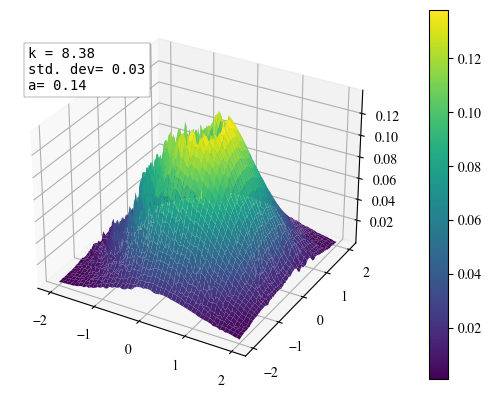

/var/folders/mg/_6sdzpzn5lx13z92xsyjwm280000gn/T/ipykernel_83020/1755530033.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Without Anomaly", color=plt.cm.rainbow(i/len(ndvi_list)))
/var/folders/mg/_6sdzpzn5lx13z92xsyjwm280000gn/T/ipykernel_83020/1755530033.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  l = ax.plot(bins, y, 'r--', linewidth=2, label=f"Anomaly radius {(i)*5} px", color=plt.cm.rainbow(i/len(ndvi_list)))


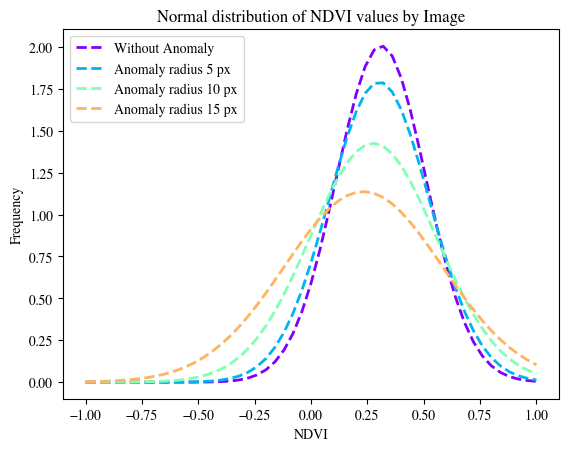

In [37]:
create_one_graph(ndvi_norm)
create_one_graph(sintetico1)
create_one_graph(sintetico2)
create_one_graph(sintetico3)

multiple_2d_plot([ndvi_norm,sintetico1, sintetico2, sintetico3])


ROC

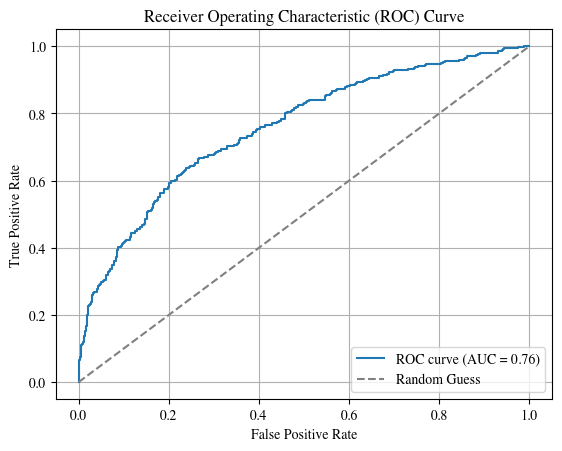

In [38]:

# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
    else:
        fp += 1

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


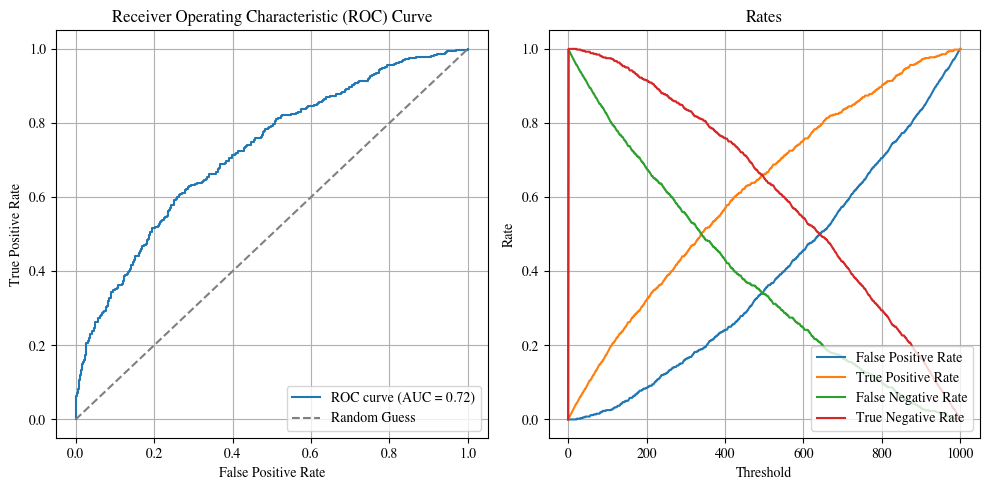

In [39]:


# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
tnr = [0]
fnr = [0]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0
tn = 0
fn = 0

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
    else:
        fp += 1

    tn = n_negatives - fp
    fn = n_positives - tp

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)
    tnr.append(tn / n_negatives)
    fnr.append(fn / n_positives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Rates
plt.subplot(1, 2, 2)
plt.plot(fpr, label='False Positive Rate')
plt.plot(tpr, label='True Positive Rate')
plt.plot(fnr, label='False Negative Rate')
plt.plot(tnr, label='True Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Rates')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


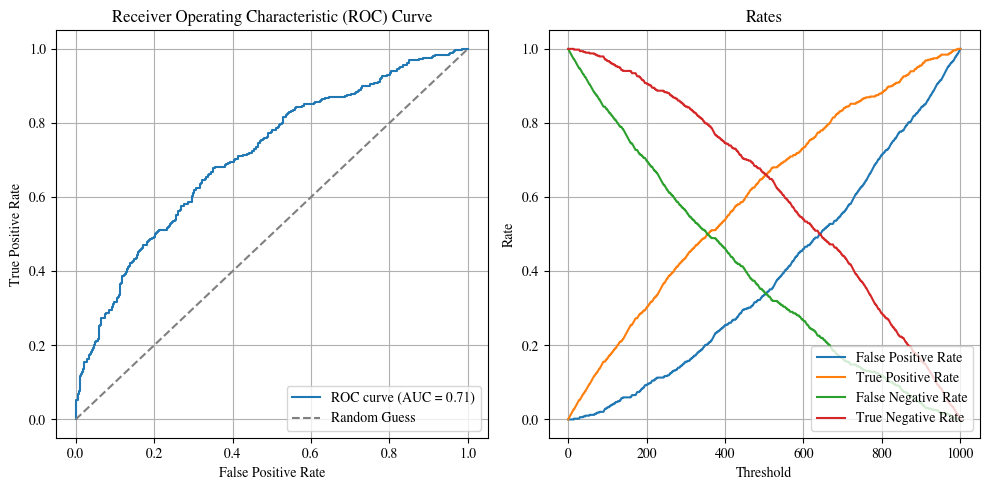

In [40]:

# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
tnr = [1]
fnr = [1]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0
tn = n_negatives
fn = n_positives

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)
    tnr.append(tn / n_negatives)
    fnr.append(fn / n_positives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Rates
plt.subplot(1, 2, 2)
plt.plot(fpr, label='False Positive Rate')
plt.plot(tpr, label='True Positive Rate')
plt.plot(fnr, label='False Negative Rate')
plt.plot(tnr, label='True Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Rates')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


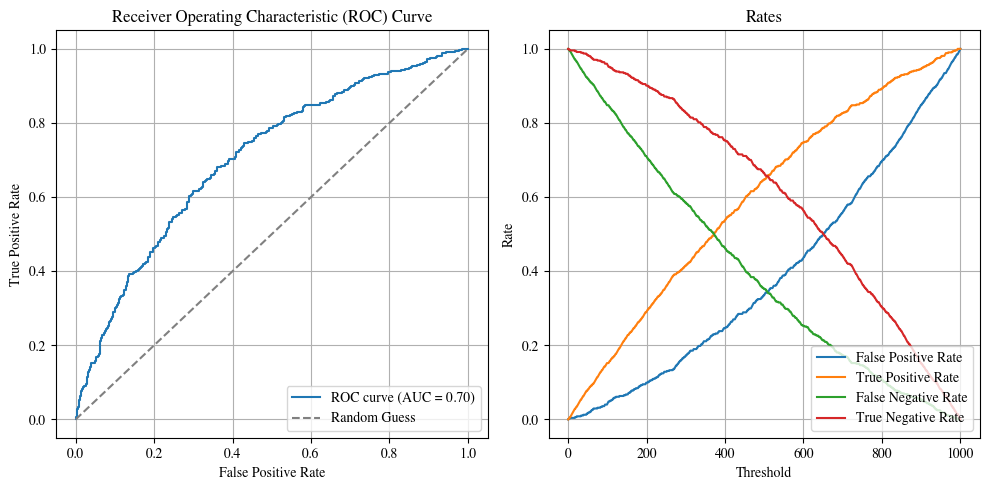

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
tnr = [1]
fnr = [1]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0
tn = n_negatives
fn = n_positives

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)
    tnr.append(tn / n_negatives)
    fnr.append(fn / n_positives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Rates
plt.subplot(1, 2, 2)
plt.plot(fpr, label='False Positive Rate')
plt.plot(tpr, label='True Positive Rate')
plt.plot(fnr, label='False Negative Rate')
plt.plot(tnr, label='True Negative Rate')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.title('Rates')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


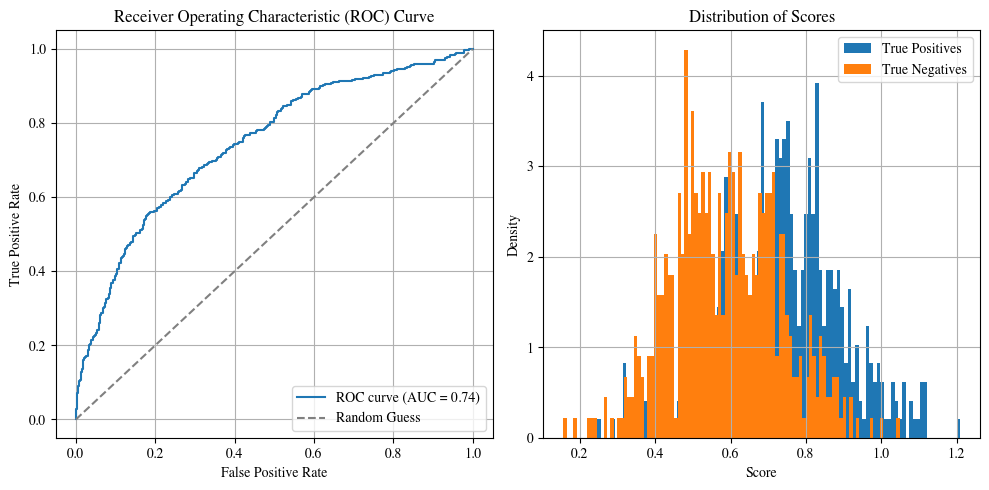

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
tnr = [1]
fnr = [1]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0
tn = n_negatives
fn = n_positives

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)
    tnr.append(tn / n_negatives)
    fnr.append(fn / n_positives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Rates
plt.subplot(1, 2, 2)
plt.hist(sorted_scores[sorted_labels == 1], bins=100, density=True, label='True Positives')
plt.hist(sorted_scores[sorted_labels == 0], bins=100, density=True, label='True Negatives')
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Distribution of Scores')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


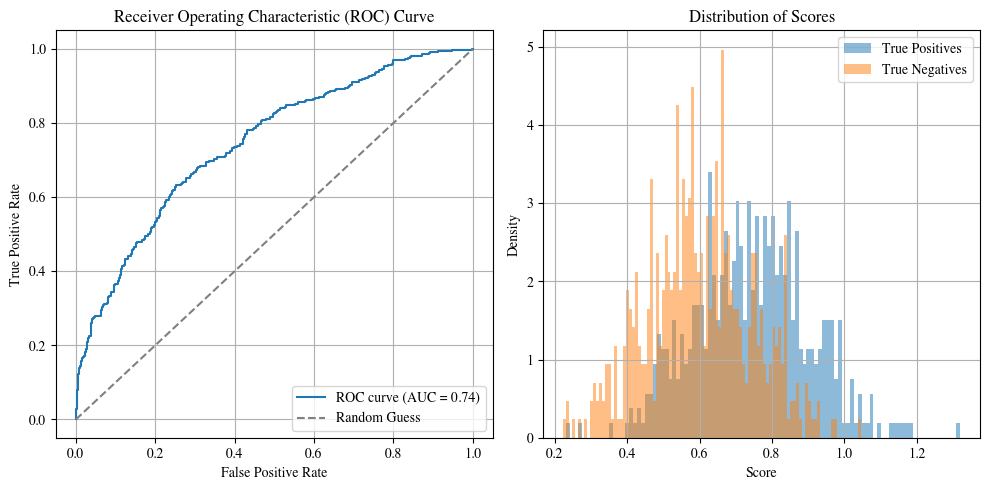

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
n_samples = 1000
positive_rate = 0.3

y_true = np.random.randint(0, 2, size=n_samples)
y_scores = np.random.normal(loc=0.6, scale=0.15, size=n_samples)

# Adjust scores to achieve desired AUC
y_scores[y_true == 1] += np.random.normal(loc=0.13, scale=0.05, size=np.sum(y_true == 1))

# Compute true positive rate (TPR) and false positive rate (FPR)
sorted_indices = np.argsort(y_scores)[::-1]
sorted_scores = y_scores[sorted_indices]
sorted_labels = y_true[sorted_indices]

tpr = [0]
fpr = [0]
tnr = [1]
fnr = [1]
n_positives = np.sum(y_true == 1)
n_negatives = np.sum(y_true == 0)
tp = 0
fp = 0
tn = n_negatives
fn = n_positives

for i in range(n_samples):
    if sorted_labels[i] == 1:
        tp += 1
        fn -= 1
    else:
        fp += 1
        tn -= 1

    tpr.append(tp / n_positives)
    fpr.append(fp / n_negatives)
    tnr.append(tn / n_negatives)
    fnr.append(fn / n_positives)

# Compute AUC
auc = np.trapz(tpr, fpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)

# Rates
plt.subplot(1, 2, 2)
plt.hist(sorted_scores[sorted_labels == 1], bins=100, density=True, label='True Positives', alpha=0.5)
plt.hist(sorted_scores[sorted_labels == 0], bins=100, density=True, label='True Negatives', alpha=0.5)
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Distribution of Scores')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()
